In [106]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

In [131]:
def nozzle_nasa_mdot(t):
    # Can represent mass inflow by increasing combined gas's density
    """
    Compute the efflux of the combustor via simple isentropic relations.
    The efficiency of the nozzle is modeled using a discharge coefficient
    :param t: time
    :return: mass flux at the outlet (efflux) of the combustion chamber.
    """
    # Avoid a unity pressure ratio at startup
    # print(gas.T)
    epsilon = 1.0
    _rho = gas.density
    _press = gas.P
    _area = 1  # arbitrarily chosen value, [m^2]
    _gamma_s = gas.cp / gas.cv
    _temp = gas.T
    _r_gas_specific = gas.cp - gas.cv
    _p_ratio = 101325 / (gas.P + epsilon)  # Exhaust pressure is atmospheric pressure

    power_1 = 2.0 / _gamma_s
    power_2 = (_gamma_s + 1.0) / (_gamma_s)
    pressure_term = _p_ratio ** power_1 - _p_ratio ** power_2
    _sqrt_term = 2. * _gamma_s * _r_gas_specific * _temp / (_gamma_s - 1.0)
    _sqrt_term *= pressure_term
    assert (_sqrt_term >= 0.0)
    _sqrt_term = np.sqrt(_sqrt_term)

    _mdot_unchoked = _rho * _area * _sqrt_term

    power = (_gamma_s + 1.0) / (_gamma_s - 1.0)
    _gamma_term = (2. / (_gamma_s + 1.0)) ** power
    _sqrt = np.sqrt(_gamma_s * _r_gas_specific * _temp * _gamma_term)
    _mdot_choked = _rho * _area * _sqrt

    _mdot = 0.0
    _p_crit_downstream = _press * (2. / (_gamma_s + 1.0)) ** (_gamma_s / (_gamma_s - 1.0))

    if _p_crit_downstream < 101325:  # Less than exhaust pressure = P_atm
        # Unchoked conditions
        _mdot = _mdot_unchoked
    else:
        # Choked conditions
        _mdot = _mdot_choked

    return _mdot  # * _geom_nozzle['C_d']  # Discharge coefficient

In [135]:
num_s = 1
r_ = np.random.uniform(size=(num_s,1))
z_ = np.random.uniform(size=(num_s,1))
# r_ = np.zeros((num_s, 1))
# z_ = np.zeros((num_s, 1))
# m = 4
# for i, rrr in enumerate(np.arange(0.05, 1, 0.3)):
#     for j, zzz in enumerate(np.arange(0.05, 1, 0.3)):
#         r_[i * m + j, 0] = rrr
#         z_[i * m + j, 0] = zzz
# for i in range(4):
#     r_[16 + i, 0] = 

#r_ = np.ones((num_s, 1)) * 0.8
#z_ = np.ones((num_s, 1)) * 0.2
e_ = np.random.normal(size=(num_s, 1))
n_t = 500
obs = np.zeros((n_t + 1, num_s))
for k in range(num_s):
    rr = r_[k,0]
    zz = z_[k,0]
    def Q(t):
        t0 = 1e-5
        r  = 1e-6
        c  = 5e11
        return c * np.exp(-(t - t0)**2 / r**2) 
        #return (1 - np.abs(rr - 0.1)) * (1 - (zz - 0.4)**2) * c * np.exp(-(t - t0)**2 / r**2) 
    gas = ct.Solution("2S_methane.cti")
    gas.Y = np.ones(gas.n_species) / gas.n_species
    gas.TP = 500, 105000
    print(gas.density)
    np.save("/home/darve/adncat/yizhou/PSAAP3/Tests/data/ini_mass_fraction.npy", gas.Y)
    np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/density.npy', gas.density)
    print(gas.P)
    r1 = ct.IdealGasReactor(gas)
    res = ct.Reservoir(gas)
    wall = ct.Wall(res, r1)
    wall.set_heat_flux(Q)
    wall.area = 1.0
    exhaust_gas = ct.Solution("2S_methane.cti")
    exhaust = ct.Reservoir(exhaust_gas)
    mfc = ct.MassFlowController(upstream = r1, downstream = exhaust, mdot = nozzle_nasa_mdot)  # mdot = nozzle_nasa_mdot
    sim = ct.ReactorNet([r1]) 
    Pt = np.zeros(n_t + 1)
    Tt = np.zeros(n_t + 1)
    Yt = np.zeros((gas.n_species,n_t + 1))
    Rhot = np.zeros(n_t + 1)
    timestep = np.zeros(n_t+1)
    Pt[0] = gas.P
    Tt[0] = gas.T
    Yt[:,0] = gas.Y
    Rhot[0] = gas.density
    timestep[0] = 0
    dt = 0
    t = 0
    for i in range(n_t):
        if (i < 125):
            dt = 5e-8
        else:
            dt = 2e-8
        t += dt
        sim.advance(t)
        timestep[i+1] = t
        #timestep[i+1] = sim.step()
        Pt[i + 1] = gas.P
        Tt[i + 1] = gas.T
        Yt[:,i + 1] = gas.Y
        Rhot[i + 1] = gas.density
    obs[:,k] = Tt
    #print(gas.density)

0.6230873908010114
105000.00000000001


/home/darve/adncat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
/home/darve/adncat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


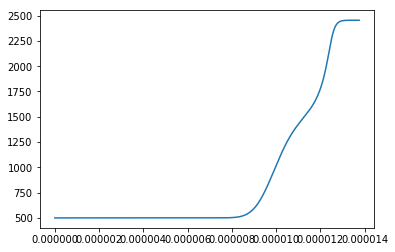

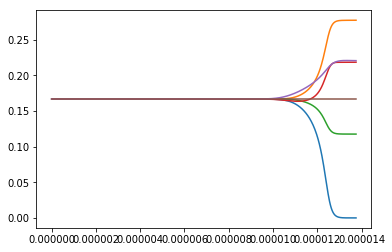

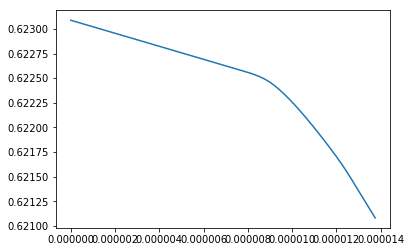

In [136]:
plt.plot(timestep, obs)
plt.figure()
for i in range(gas.n_species):
    plt.plot(timestep, Yt[i,:])
####
plt.figure()
plt.plot(timestep, Rhot)

In [137]:
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/obs.npy', obs)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/r_.npy', r_)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/z_.npy', z_)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/total_mass.npy', Rhot)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pressure.npy', Pt)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature.npy', Tt)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/mass_fraction.npy', Yt)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/timestep.npy', timestep)
tbd = []
falofr = []
elmr = []
for i in range(gas.n_reactions):
    if (isinstance(gas.reaction(i), ct.ThreeBodyReaction)):
        tbd.append(i)
    elif (isinstance(gas.reaction(i), ct.FalloffReaction)):
        falofr.append(i)
    else:
        elmr.append(i)

NASA_coeffs = []
for i in range(gas.n_species):
    NASA_coeffs.append(gas.species(i).thermo.coeffs)
NASA_coeffs = np.array(NASA_coeffs)
reactants = []
orders = [] 
Af = np.zeros(len(elmr))
beta = np.zeros(len(elmr))
E = np.zeros(len(elmr))

rec2ind = dict()
for i in range(gas.n_species):
    reactants.append(gas.species(i).name)
    rec2ind[gas.species(i).name] = i
orders = gas.reactant_stoich_coeffs()[:,elmr]
for i, s in enumerate(elmr):   
    Af[i] = gas.reaction(s).rate.pre_exponential_factor
    beta[i] = gas.reaction(s).rate.temperature_exponent
    E[i] = gas.reaction(s).rate.activation_energy
    for rec in gas.reaction(s).orders:
        orders[rec2ind[rec], i] = gas.reaction(s).orders[rec]
reversible = np.array([int(gas.reaction(i).reversible) for i in range(gas.n_reactions)])

np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/NASA_coeffs.npy', NASA_coeffs)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/molecular_weights.npy',gas.molecular_weights)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reactants_stoich_coeffs.npy',gas.reactant_stoich_coeffs())
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/product_stoich_coeffs.npy',gas.product_stoich_coeffs())
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reaction_orders.npy',orders)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor.npy', Af)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent.npy', beta)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy.npy', E)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/delta_standard_entropy.npy', gas.delta_standard_entropy)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/delta_standard_enthalpy.npy', gas.delta_standard_enthalpy)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reversible.npy', reversible)

efficiency_f = np.zeros((gas.n_species, len(falofr)))
Af_lo = np.zeros(len(falofr))
beta_lo = np.zeros(len(falofr))
E_lo = np.zeros(len(falofr))
Af_hi = np.zeros(len(falofr))
beta_hi = np.zeros(len(falofr))
E_hi = np.zeros(len(falofr))
orders_f = gas.reactant_stoich_coeffs()[:,falofr]
falloff_parameters = np.zeros((4, len(falofr)))
troefall = []
troefall_coeff = []
for i, s in enumerate(falofr):
    rr = gas.reaction(s)
    Af_lo[i] = rr.low_rate.pre_exponential_factor
    beta_lo[i] = rr.low_rate.temperature_exponent
    E_lo[i] = rr.low_rate.activation_energy
    Af_hi[i] = rr.high_rate.pre_exponential_factor
    beta_hi[i] = rr.high_rate.temperature_exponent
    E_hi[i] = rr.high_rate.activation_energy
    efficiency_f[:,i] = rr.default_efficiency * np.ones(gas.n_species)
    if(isinstance(rr.falloff, ct.TroeFalloff)):
        troefall.append(i)
        troefall_coeff.append(rr.falloff.parameters)
    #falloff_parameters[:,i] = gas.reaction(s).falloff.parameters
    for rec in rr.efficiencies:
        efficiency_f[rec2ind[rec]] = rr.efficiencies[rec]
    for rec in gas.reaction(s).orders:
        orders_f[rec2ind[rec], i] = gas.reaction(s).orders[rec]

np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/efficiency_f.npy', efficiency_f)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/troefall_coeff.npy', np.array(troefall_coeff).T)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/troefall.npy', troefall)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reaction_orders_f.npy',orders_f)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_hi.npy', Af_hi)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_hi.npy', beta_hi)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_hi.npy', E_hi)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_lo.npy', Af_lo)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_lo.npy', beta_lo)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_lo.npy', E_lo)

efficiency_t = np.zeros((gas.n_species, len(tbd)))
Af_t = np.zeros(len(tbd))
beta_t = np.zeros(len(tbd))
E_t = np.zeros(len(tbd))
orders_t = gas.reactant_stoich_coeffs()[:,tbd]
for i, s in enumerate(tbd):
    rr = gas.reaction(s)
    Af_t[i] = rr.rate.pre_exponential_factor
    beta_t[i] = rr.rate.temperature_exponent
    E_t[i] = rr.rate.activation_energy
    efficiency_t[:,i] = rr.default_efficiency * np.ones(gas.n_species)
    for rec in rr.efficiencies:
        efficiency_t[rec2ind[rec]] = rr.efficiencies[rec]
    for rec in gas.reaction(s).orders:
        orders_t[rec2ind[rec], i] = gas.reaction(s).orders[rec]
        
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/efficiency_t.npy',efficiency_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reaction_orders_t.npy',orders_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_t.npy', Af_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_t.npy', beta_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_t.npy', E_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/tbd.npy',tbd)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/falofr.npy',falofr)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/elmr.npy',elmr)

In [74]:
r = np.random.uniform(size=(10,))
z = np.random.uniform(size=(10,))